# 神经网络中的可视化

对于神经网络，我们介绍一下几种可视化方面的工作，其目的各有不同。有的是为了展示keras现成的网络结构的可视化；有的是为了展示如何灵活地调用keras的各种数据接口，从而深入获取建模中所得到的数据；有的是为了展示模型中什么样的特征比较重要。

1. keras本身的网络结构可视化工具；
2. 深入keras的数据接口，了解keras的进阶用法；
3. 模型特征的可视化

# 网络结构的可视化

神经网络是一个图结构的模型，通过可视化可以更清楚的看清楚其结构。

In [1]:
%matplotlib inline

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16, 12)

#在maplotlib的图中显示中文
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体  
plt.rcParams['axes.unicode_minus'] = False #解决图像中中文符号显示为方块的问题 

d:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


在python里，需要导入pydot库。但是在安装TF之后，使用pip安装会报告 “TypeError: parse() got an unexpected keyword argument 'transport_encoding'”， 因此我们改用conda安装，并且设定好-y选项不做人工确认：
<code>
    conda install -y pydot graphviz
</code>

另外，我们需要安装Graphiviz可执行文件，因为pydotplus依赖于这个程序的Dot语言进行画图。

如果是Windows操作系统，去__[这个地址](https://graphviz.gitlab.io/_pages/Download/Download_windows.html)__ 下载可执行文件，并采用如下操作：

1. 点击安装文件安装 GraphViz 
2. 找到 gvedit.exe 文件的安装位置。如果是缺省值安装，位置在："C:\Program Files (x86)\Graphviz2.34\bin\"
3. 把这个路径加入到系统的PATH变量中 
4. 重新启动command console，并打开jupyter notebook或者其他python IDE


In [2]:
import pydotplus, pydot
#import graphviz

In [3]:
from keras.layers import Dense, Activation, LSTM
from keras.models import Sequential, Model
from keras.applications import VGG16

## 下面我们看看来画出VGG16的结构

In [5]:
model = VGG16(include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [32]:
keras.utils.plot_model(model, to_file='./images/vgg16_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

rankdir 指图是垂直的还是水平的。TB指定用垂直方向画图（意思指Top to Bottom）；LR指从左到右画图（Left to Right）
![VGGmodel](./images/vgg16_model.png)

In [33]:
model = keras.applications.Xception(include_top=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [6]:
keras.utils.plot_model(model, to_file='./images/xception_model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

![xception](./images/xception_model.png)

## 通过keras的各种数据接口获取数据画图

keras提供了非常灵活的数据接口，可以获得很多建模过程的信息，包括参数，损失函数等。这些数据可以用来绘制很多模型的信息。这里我们主要通过两个例子来讲解如何使用这些接口。需要注意的是，这些接口大部分在keras.io的网页上有明确说明，但是也有一些没有，需要查阅源代码。这也是keras的一个优势，即keras基于python，因此源代码非常易读易懂。

### 绘制激活函数

一般来说，绘制激活函数我们只需要将激活函数的公式用矩阵运算列出即可，一般都非常简单。但是这里我们将要使用keras来实现，主要目的是为了展示获取数据的接口，尤其是对模型对象的操作。

这里我们先定义一个简单的神经网络模型，该模型由一个输入层，一个全连接隐含层和一个输出层构成。待考察的激活函数就在全连接隐含层中定义，输出层只定义一个线性激活函数，这样在后面可视化的时候我们看到的数据形态就完全有全连接隐含层中的激活函数来形成。出于简化考虑，我们的输入变量只考虑了一个向量。

在这个例子中我们要学习到：

1. 抓取模型层的信息
2. 使用后台function函数

In [8]:
from keras import backend as K

In [7]:
x = np.linspace(-50, 50, 500)
y = x**2 + 5

x = x.astype('float32')
y = y.astype('float32')

model = Sequential()
model.add(Dense(1, input_shape=(1,), activation='relu', name='Hidden'))
model.add(Dense(1, activation='linear', name='Output'))
model.summary()
model.compile(loss='mse', optimizer='adam')
#model.fit(x, x, epochs=3, batch_size=128, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden (Dense)               (None, 1)                 2         
_________________________________________________________________
Output (Dense)               (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [9]:
inp = model.input                                           # 输入
outputs = [layer.output for layer in model.layers if layer.name=='Hidden']          # 抓取所需网络层，实际这里最关键的只有激活层
#outputs = [layer.output for layer in model.layers]
functions = [K.function([inp], [out]) for out in outputs]    # K.function()使用tenforflow后台初始化一个计算函数

[[18.314903]
 [18.241497]
 [18.16809 ]
 [18.094685]
 [18.021278]]


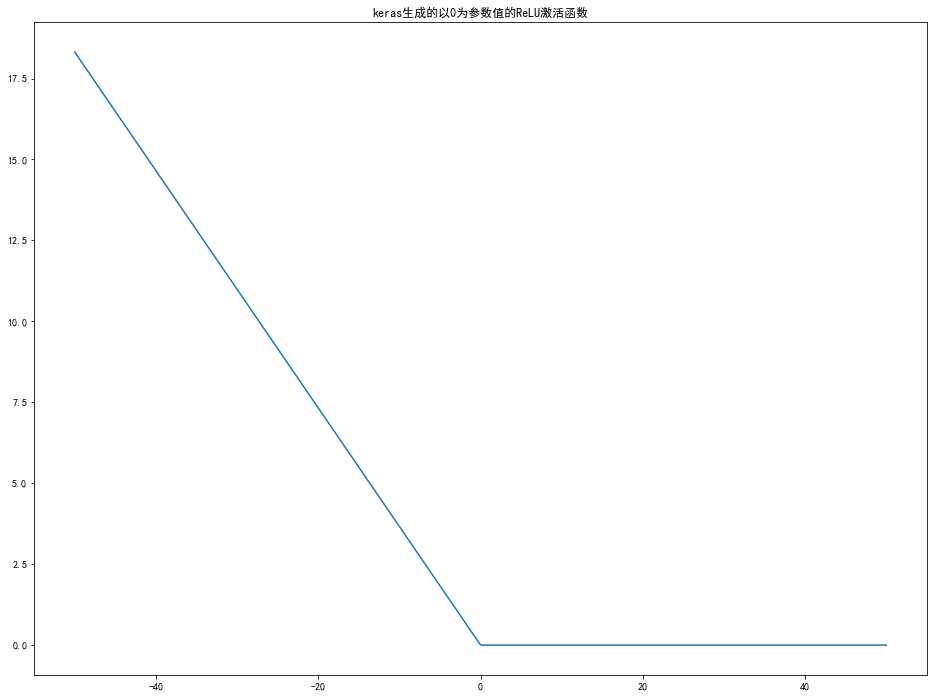

In [10]:
# 验证结果

layer_outs = [func([x.reshape(-1, 1)]) for func in functions]
print(layer_outs[0][0][:5])
activationLayer = layer_outs[0][0]
    
activationDf = pd.DataFrame(activationLayer)
plt.plot(x, activationDf)   
plt.title(u'keras生成的以0为参数值的ReLU激活函数')
plt.show()

In [11]:
def NNmodel(activationFunc='linear'):
    '''
       定义一个神经网络模型。如果要定义不同的模型，可以直接修改该函数
    '''
    if (activationFunc=='softplus') | (activationFunc=='sigmoid'):
        winit='lecun_uniform'
    elif activationFunc=='hard_sigmoid':
        winit='lecun_normal'
    else:
        winit='he_uniform'
    model = Sequential()
    model.add(Dense(1, input_shape=(1,), activation=activationFunc, 
                    kernel_initializer=winit, 
                    name='Hidden'))
        
    model.add(Dense(1, activation='linear', name='Output'))   
    model.compile(loss='mse', optimizer='sgd')    
    return model

def VisualActivation(activationFunc='relu', plot=True):    
    #x = (np.arange(100)-50)/10
    #y = np.log(x+x.max()+1)
    x = np.linspace(-5, 5, 500).astype('float32')
    y = np.log(x**2 + 5).astype('float32')
    
    model = NNmodel(activationFunc = activationFunc)
    #model.fit(x, y, epochs=1, batch_size=2014)
    
    inX = model.input                                          
    outputs = [layer.output for layer in model.layers if layer.name=='Hidden']     
    functions = [K.function([inX], [out]) for out in outputs]   
    
    layer_outs = [func([x.reshape(-1, 1)]) for func in functions]
    activationLayer = layer_outs[0][0]
        
    activationDf = pd.DataFrame(activationLayer)
    result=pd.concat([pd.DataFrame(x), activationDf], axis=1)
    result.columns=['X', 'Activated']
    result.set_index('X', inplace=True)
    if plot:
        result.plot(title=f)
    
    return result

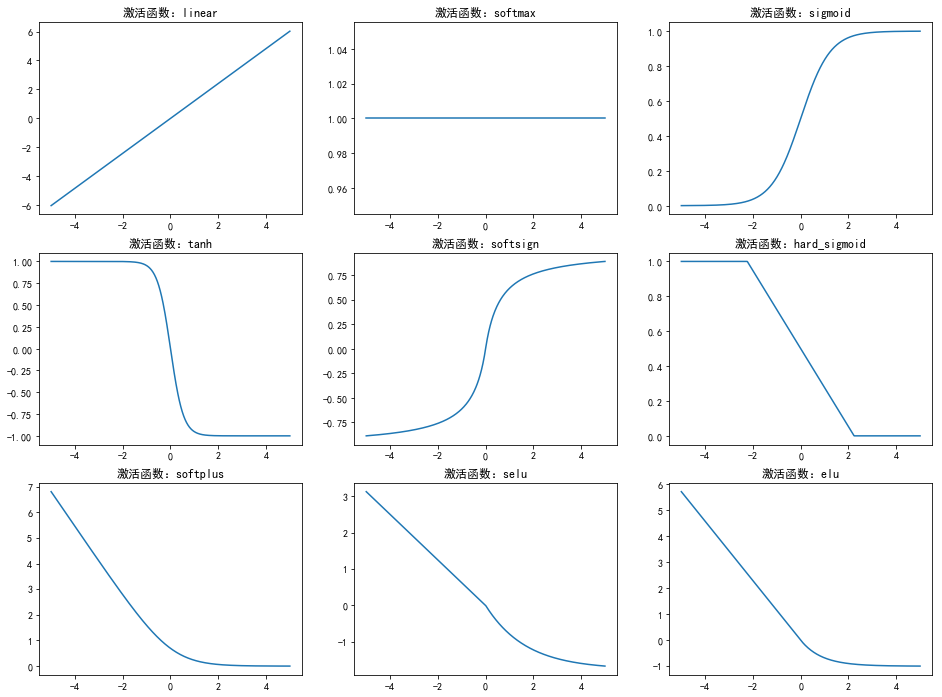

In [12]:
actFuncs = ['linear', 'softmax', 'sigmoid', 'tanh', 'softsign', 'hard_sigmoid', 'softplus', 'selu', 'elu']

from keras.layers import LeakyReLU
figure = plt.figure()
for i, f in enumerate(actFuncs):
    # 依次画图
    figure.add_subplot(3, 3, i+1)
    out=VisualActivation(activationFunc=f, plot=False)
    plt.plot(out.index, out.Activated)
    plt.title(u'激活函数：'+f)

### 演示不同求解引擎的参数求解路径

这里我们的主要目的是考察不同损失函数的空间曲面以及参数在不同优化引擎下的的求解路径。与此同时我们可以学习到keras模型类对象自带的特性和方法，并灵活运用。

出于简化的目的，我们首先只根据MNIST数据集训练简单的多层感知器模型（MLP）。然后选择两个参数考察求解路径和损失函数的曲面。

这里我们要学习用到

1. 使用callback保存历史求解信息，使用ModelCheckpoint指定那些信息需要保存
2. 载入模型
3. 定制模型参数
4. 模型evaluate

In [37]:
import h5py
import keras.backend as K

from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation

In [44]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.reshape(X_train.shape[0],32*32*3).astype('float32')
X_test = X_test.reshape(X_test.shape[0],32*32*3).astype('float32')
X_train /= 255
X_test /= 255

target = to_categorical(y_train)

u,s,v = np.linalg.svd(X_train, full_matrices=False)

In [54]:
np.cumsum(s[:50])/np.sum(s)

array([0.1095956 , 0.12952857, 0.14489779, 0.1560412 , 0.16665693,
       0.17605941, 0.1852056 , 0.1933972 , 0.20150797, 0.20816691,
       0.21452431, 0.22026339, 0.22595674, 0.23152138, 0.23684315,
       0.24186343, 0.24664915, 0.25136855, 0.25599942, 0.26045293,
       0.26473492, 0.26899254, 0.27290237, 0.27679253, 0.2806435 ,
       0.2844336 , 0.28816408, 0.29186267, 0.2953795 , 0.29886445,
       0.30222774, 0.3054327 , 0.30859327, 0.31168625, 0.31476596,
       0.31776267, 0.32060164, 0.32342908, 0.32622963, 0.3289971 ,
       0.3317325 , 0.33439213, 0.3370446 , 0.33965802, 0.34220424,
       0.34472954, 0.34716555, 0.3495884 , 0.35197455, 0.3543415 ],
      dtype=float32)

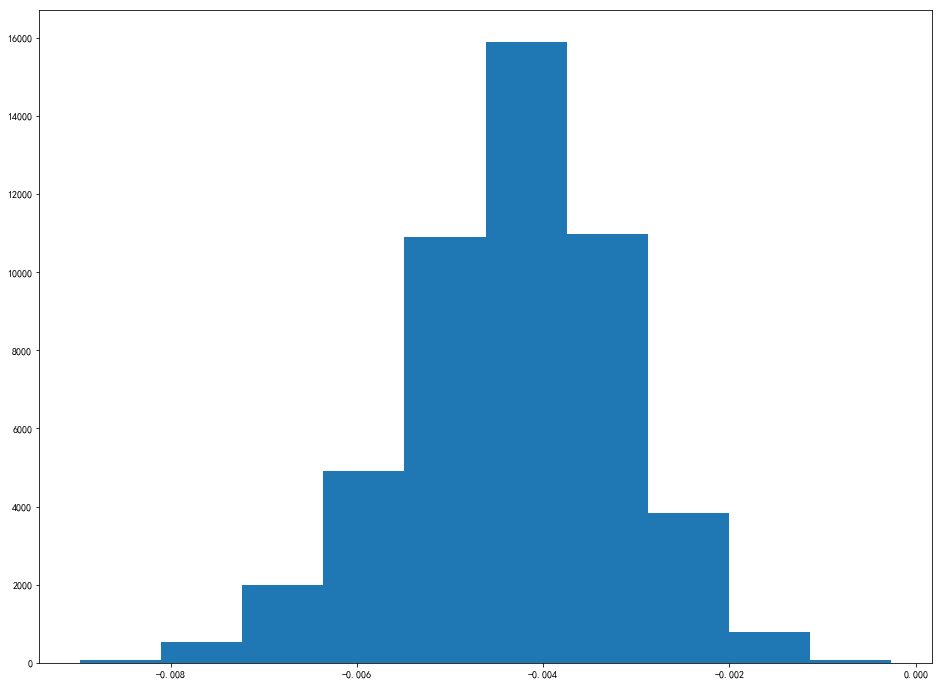

In [47]:
plt.hist(u[:, 0]);

In [50]:
# Now build a MLP based on first 2 eigenvectors
u2 = u[:, [1,2]]

def GetModel(lossfunction='categorical_crossentropy', optimizer='adam'):
    model = Sequential()
    model.add(Dense(4, activation='relu', input_shape=(2,), name='Hidden0'))
    #model.add(Dense(8, activation='relu', name='Hidden1'))
    model.add(Dense(10, input_shape=(2,), activation='softmax', name='Output'))
    model.summary()
    model.compile(loss=lossfunction, optimizer=optimizer, metrics=['accuracy'])
    return model

model=GetModel(lossfunction='categorical_crossentropy', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden0 (Dense)              (None, 4)                 12        
_________________________________________________________________
Output (Dense)               (None, 10)                50        
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Now fit the model
wgtsfile='./data/EstimationHistory_{epoch:02d}.h5'
checkpoint = ModelCheckpoint(wgtsfile, monitor='loss', 
                             verbose=0, save_best_only=False, save_weights_only=False, 
                             mode='auto', period=1)
%time model.fit(u2.astype('float32'), target.astype('float32'), batch_size=4069, epochs=50, verbose=1, callbacks=[checkpoint])

Epoch 1/50
50000/50000 [==============================] - 1s 20us/step - loss: 2.3021 - acc: 0.1180
Epoch 2/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3019 - acc: 0.1002
Epoch 3/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3018 - acc: 0.1037
Epoch 4/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3018 - acc: 0.1165
Epoch 5/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3017 - acc: 0.1217
Epoch 6/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3016 - acc: 0.1196
Epoch 7/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3016 - acc: 0.1187
Epoch 8/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3015 - acc: 0.1292
Epoch 9/50
50000/50000 [==============================] - 0s 3us/step - loss: 2.3014 - acc: 0.1507
Epoch 10/50
50000/50000 [==============================] - 0s 2us/step - loss: 2.3013 - acc: 0.1485
Epoch 11

In [17]:
%%time
# load the checkpoint file to see what's inside
from keras.models import load_model
model_nocompiled = load_model('./data/EstimationHistory_' + str(4).zfill(2) + '.h5', compile=False)
model_compiled = load_model('./data/EstimationHistory_' + str(4).zfill(2) + '.h5', compile=True)


Wall time: 822 ms


In [18]:
model_nocompiled.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden0 (Dense)              (None, 4)                 12        
_________________________________________________________________
Hidden1 (Dense)              (None, 8)                 40        
_________________________________________________________________
Output (Dense)               (None, 10)                90        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_nocompiled.evaluate(u2.astype('float32'), target.astype('float32'), batch_size=4096)

RuntimeError: The model needs to be compiled before being used.

In [20]:
model_compiled.evaluate(u2.astype('float32'), target.astype('float32'), batch_size=4096)

60000/60000 [==============================] - 0s 2us/step


[2.3023695121765138, 0.11236666667461395]

In [22]:
modelwgt = model_compiled
print(modelwgt.get_weights())

[array([[-0.00986881,  0.46450323,  0.57462484, -0.5852247 ],
       [-0.02000904, -0.7164826 , -0.48998585, -0.3147077 ]],
      dtype=float32), array([ 0.00157642, -0.00143011,  0.00070391, -0.00254376], dtype=float32), array([[ 0.24561587, -0.47151262, -0.13676745, -0.61172724, -0.20322269,
         0.44415912, -0.0195866 , -0.45280728],
       [-0.01046357, -0.00875831, -0.6854932 ,  0.306705  ,  0.4995266 ,
        -0.26831943,  0.5000704 ,  0.6051709 ],
       [-0.22596306, -0.38909867,  0.60103345,  0.24783   , -0.24892661,
         0.2231364 ,  0.3473218 ,  0.42030323],
       [ 0.2674867 , -0.6644316 ,  0.5309412 , -0.25273868, -0.43869206,
         0.29123545,  0.70393866,  0.20235454]], dtype=float32), array([-0.00094013,  0.        , -0.00205009,  0.00117332,  0.00073053,
       -0.00062814, -0.00385274, -0.005217  ], dtype=float32), array([[ 0.5451352 , -0.40413633,  0.3158654 , -0.36894414,  0.06939068,
        -0.35946038,  0.38877982, -0.00336858, -0.5061256 ,  0.472911

In [23]:
count = 0
for layer in modelwgt.layers:
    count += 1
    name = layer.name
    weights = layer.get_weights() # list of numpy arrays
    print(name, weights)

Hidden0 [array([[-0.00986881,  0.46450323,  0.57462484, -0.5852247 ],
       [-0.02000904, -0.7164826 , -0.48998585, -0.3147077 ]],
      dtype=float32), array([ 0.00157642, -0.00143011,  0.00070391, -0.00254376], dtype=float32)]
Hidden1 [array([[ 0.24561587, -0.47151262, -0.13676745, -0.61172724, -0.20322269,
         0.44415912, -0.0195866 , -0.45280728],
       [-0.01046357, -0.00875831, -0.6854932 ,  0.306705  ,  0.4995266 ,
        -0.26831943,  0.5000704 ,  0.6051709 ],
       [-0.22596306, -0.38909867,  0.60103345,  0.24783   , -0.24892661,
         0.2231364 ,  0.3473218 ,  0.42030323],
       [ 0.2674867 , -0.6644316 ,  0.5309412 , -0.25273868, -0.43869206,
         0.29123545,  0.70393866,  0.20235454]], dtype=float32), array([-0.00094013,  0.        , -0.00205009,  0.00117332,  0.00073053,
       -0.00062814, -0.00385274, -0.005217  ], dtype=float32)]
Output [array([[ 0.5451352 , -0.40413633,  0.3158654 , -0.36894414,  0.06939068,
        -0.35946038,  0.38877982, -0.0033685

In [24]:
print(weights[0].reshape(-1, 2)[1])
hidden1=modelwgt.get_layer(name='Output')
wgt=hidden1.get_weights()
print(len(wgt[0].shape))

[ 0.3158654  -0.36894414]
2


In [55]:
%%time

def loadwgts(wgtfile, layerName):
    model = load_model(wgtfile, compile=False)
    layer = model.get_layer(name=layerName)
    wgts = layer.get_weights()
    if len(wgts[0].shape)==1:
        return wgts[0]
    else:
        return wgts[0].reshape(-1, 2)[3]

allwgts = {}
for i in range(50):
    filename='./data/EstimationHistory_' + str(i+1).zfill(2) + '.h5'    
    allwgts[i] = loadwgts(filename, 'Output')
    #print(filename)
    
allwgtsDf=pd.DataFrame.from_dict(allwgts, orient='index')
allwgtsDf.columns=['w1', 'w2']

Wall time: 28.6 s


在得到模型以后，可以通过evaluate方法求得给定参数下的损失函数曲面。因此我们可以通过meshgrid方法来获取我们需要考察的两个参数的区间之间的网格，并逐一通过set_weights方法修改模型参数，然后求得相应的损失函数值，从而得到对应meshgrid的损失函数曲面。

**这里需要注意的是**，在画参数求解路径的时候一定要保持原有求解过程的次序。

In [33]:
print(model.evaluate(u2.astype('float32'), target.astype('float32'), batch_size=4096))
model.metrics_names

60000/60000 [==============================] - 0s 4us/step
[2.208655384190877, 0.2007166667620341]


['loss', 'acc']

In [56]:
%%time 

xmin, xmax = allwgtsDf.w1.min(), allwgtsDf.w1.max()
xsteps = (xmax-xmin)/50
ymin, ymax = allwgtsDf.w2.min(), allwgtsDf.w2.max()
ysteps = (ymax-ymin)/50

xmesh, ymesh = np.meshgrid(np.arange(xmin-xsteps, xmax + xsteps, xsteps), np.arange(ymin-ysteps, ymax + ysteps, ysteps) )
z=np.zeros(xmesh.shape)
print(xmin, xmax, ymin, ymax)
weights = model.get_weights()
#print(weights[0])
weights2=weights
model2 = model
for i in range(xmesh.shape[0]):
    for j in range(xmesh.shape[1]):
        weights2[0][0]=xmesh[i,j]
        weights2[0][1]=ymesh[i,j]        
        model2.set_weights(weights2)
        res = model2.evaluate(u2.astype('float32'), target.astype('float32'), verbose=0, batch_size=4096)
        z[i, j]= res[0]
        #print(xmesh[i, j])
    if i % 10 ==0:
        print(i, z[i, j], xmesh[i, j])

-0.15242953598499298 -0.14845135807991028 -0.6606312990188599 -0.6565285325050354
0 2.3024699687194823 -0.14845135807991033
10 2.3024697262573244 -0.14845135807991033
20 2.302469565963745 -0.14845135807991033
30 2.3024694056701662 -0.14845135807991033
40 2.302469245376587 -0.14845135807991033
50 2.302469081039429 -0.14845135807991033
Wall time: 2min 19s


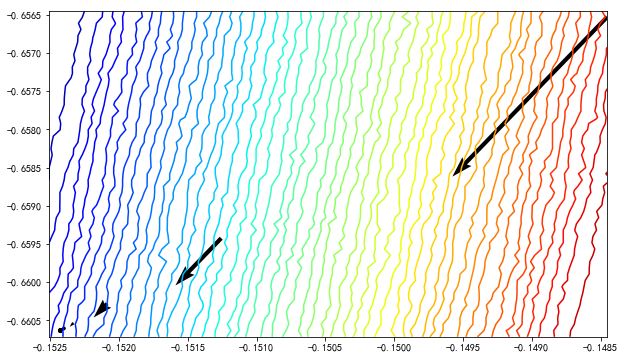

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

path = allwgtsDf.values.T

ax.contour(xmesh, ymesh, z, levels=sorted(set(np.percentile(z, np.linspace(0, 100, 50)))), norm=None, cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
          scale_units='xy', angles='uv', scale=2, color='black')
#ax.colorbar()
plt.show()        

# 神经网络模型效果的可视化

在我们已经建立好模型之后，我们通常需要检验模型的是否真的实现了预定的预测学习目的，验证那些特征是对模型有效的，以及模型效果的评估。这种模型的可视化是更多人理解意义上的可视化，主要用于图像建模的领域。我们使用keras-vis这个库来进行操作。该库支持：

1. Activation maximization : 逆向求得一个图形输入，每个像素都是由最大化激活函数的边际效益得到的，有点点类似于GAN。
2. Saliency maps ： 查看所学特征是否是真的预期的特征，因此是attention机制的可视化。其通过输出对于输入的边际效用得到，有点类似于PDP的概念。
3. Class activation maps ： 是attention机制的另外一种可视化，但是其计算依赖于倒数第二的卷积层输出相对于输入的边际效用。


我们下面来看一个使用fashion MNIST数据建立的一个类似于VGG的模型。

In [11]:
import io, gzip, requests
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.optimizers import SGD

np.random.seed(962342)

In [4]:
train_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
train_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
test_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
test_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

def readRemoteGZipFile(url, isLabel=True):
    response=requests.get(url, stream=True)
    gzip_content = response.content
    fObj = io.BytesIO(gzip_content)
    content = gzip.GzipFile(fileobj=fObj).read()
    if isLabel:
        offset=8
    else:
        offset=16
    result = np.frombuffer(content, dtype=np.uint8, offset=offset)    
    return(result)

In [5]:
train_labels = readRemoteGZipFile(train_label_url, isLabel=True)
train_images_raw = readRemoteGZipFile(train_image_url, isLabel=False)

test_labels = readRemoteGZipFile(test_label_url, isLabel=True)
test_images_raw = readRemoteGZipFile(test_image_url, isLabel=False)

In [6]:
train_images = train_images_raw.reshape(len(train_labels), 784)
test_images = test_images_raw.reshape(len(test_labels), 784)

X_train = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
X_test = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

X_train /= 255
X_test /= 255

Y_train = train_labels
Y_test = test_labels
Y_train2 = keras.utils.to_categorical(Y_train).astype('float32')
Y_test2 = keras.utils.to_categorical(Y_test).astype('float32')

In [12]:
num_classes = len(set(Y_train))
model2=Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
          input_shape=X_train.shape[1:], activation='relu', name='Conv1a'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', name='Conv1b'))
model2.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling1'))
model2.add(Dropout(0.5, name='Dropout1'))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', name='Conv2a'))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding="valid", activation='relu', name='Conv2b'))
model2.add(MaxPooling2D(pool_size=(3, 3), name='MaxPooling2'))
model2.add(Dropout(0.5, name='Dropout2'))
model2.add(Flatten(name='Flatten'))
model2.add(Dense(256, name='Dense1'))
model2.add(Activation('relu'))
model2.add(Dropout(0.5, name='Dropout3'))
model2.add(Dense(256, name='Dense2'))
model2.add(Activation('relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax', name='preds'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1a (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
Conv1b (Conv2D)              (None, 28, 28, 64)        18496     
_________________________________________________________________
MaxPooling1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2a (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
Conv2b (Conv2D)              (None, 12, 12, 256)       295168    
_________________________________________________________________
MaxPooling2 (MaxPooling2D)   (None, 4, 4, 256)         0         
__________

In [13]:
wgt_file = './data/mnist_vgg_weights.hdf5'
checkpointer = ModelCheckpoint(filepath=wgt_file, verbose=0, save_best_only=False)
model2_fit=model2.fit(X_train, Y_train2, validation_data = (X_test, Y_test2), epochs=40, 
                      verbose=1, batch_size=1024, callbacks=[checkpointer])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 14s 233us/step - loss: 0.9836 - acc: 0.6261 - val_loss: 0.5477 - val_acc: 0.7814
Epoch 2/40
60000/60000 [==============================] - 10s 169us/step - loss: 0.5166 - acc: 0.8064 - val_loss: 0.4091 - val_acc: 0.8484
Epoch 3/40
60000/60000 [==============================] - 10s 172us/step - loss: 0.4209 - acc: 0.8462 - val_loss: 0.3411 - val_acc: 0.8730
Epoch 4/40
60000/60000 [==============================] - 10s 172us/step - loss: 0.3673 - acc: 0.8647 - val_loss: 0.3171 - val_acc: 0.8839
Epoch 5/40
60000/60000 [==============================] - 10s 173us/step - loss: 0.3348 - acc: 0.8774 - val_loss: 0.2979 - val_acc: 0.8855
Epoch 6/40
60000/60000 [==============================] - 10s 172us/step - loss: 0.3111 - acc: 0.8859 - val_loss: 0.2759 - val_acc: 0.8959
Epoch 7/40
60000/60000 [==============================] - 10s 172us/step - loss: 0.2907 - acc: 0.8926 - val_loss: 0.

In [ ]:
model2.save('./data/model2.h5')

如果要正确执行下面的神经网络特征可视化代码，要么升级keras-vis，到其 __[github](https://github.com/raghakot/keras-vis)__ 下载最新的代码并安装，要么用下面的代码到anaconda的site-packages\中对应的代码包中替换同名函数，并重启python。

In [21]:
import tempfile
def apply_modifications(model):
    """Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.

    Args:
        model: The `keras.models.Model` instance.

    Returns:
        The modified model with changes applied. Does not mutate the original `model`.
    """
    # The strategy is to save the modified model and load it back. This is done because setting the activation
    # in a Keras layer doesnt actually change the graph. We have to iterate the entire graph and change the
    # layer inbound and outbound nodes with modified tensors. This is doubly complicated in Keras 2.x since
    # multiple inbound and outbound nodes are allowed with the Graph API.
    #model_path = '/tmp/' + next(tempfile._get_candidate_names()) + '.h5'
    with tempfile.TemporaryDirectory() as td:
        model_path = td + next(tempfile._get_candidate_names()) + '.h5'

    model_path.replace('\\', '/')
    print(model_path)
    try:
        model.save(model_path)
        return load_model(model_path)
    finally:
        os.remove(model_path)

C:\Users\xieliang\AppData\Local\Temp\tmpoj3ggj91a2_58id4.h5


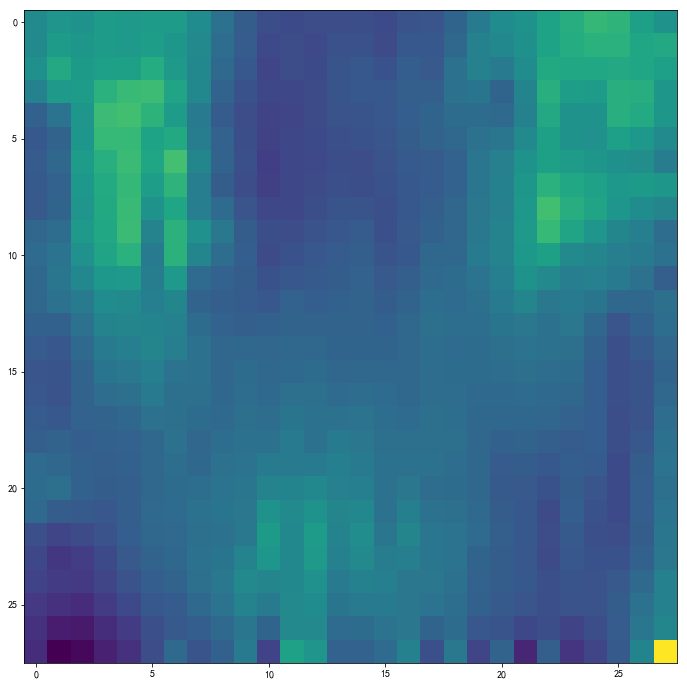

In [23]:
from vis.visualization import visualize_activation
from vis.utils import utils

#找到最后一层
layer_idx = utils.find_layer_idx(model2, 'preds')

# 把最后一层的softmax激活函数替换为线性
model2.layers[layer_idx].activation = keras.activations.linear
model2 = utils.apply_modifications(model2)

# 最大化第一层的滤子
filter_idx = 0
img = visualize_activation(model2, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

### 显示关注机制

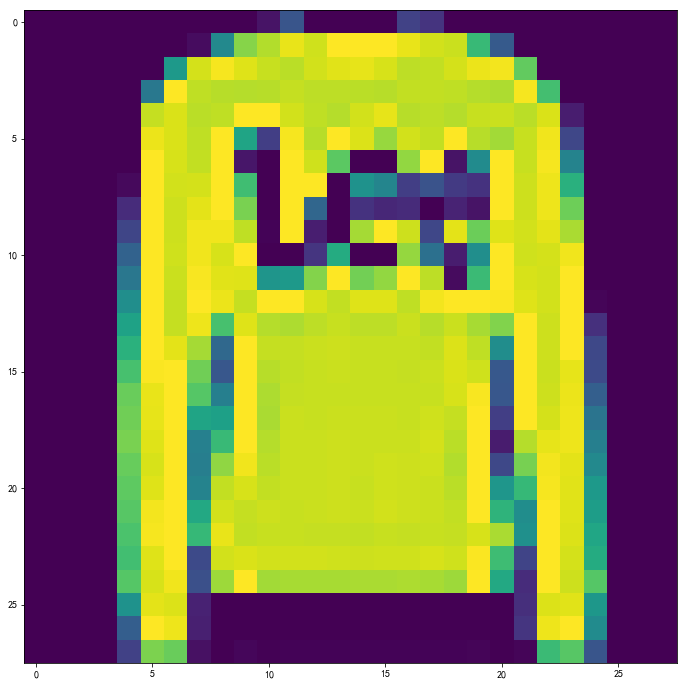

In [25]:
class_idx = 0
indices = np.where(Y_train2[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

plt.imshow(X_test[idx][..., 0])

C:\Users\xieliang\AppData\Local\Temp\tmpsqiwz514ctxif44x.h5


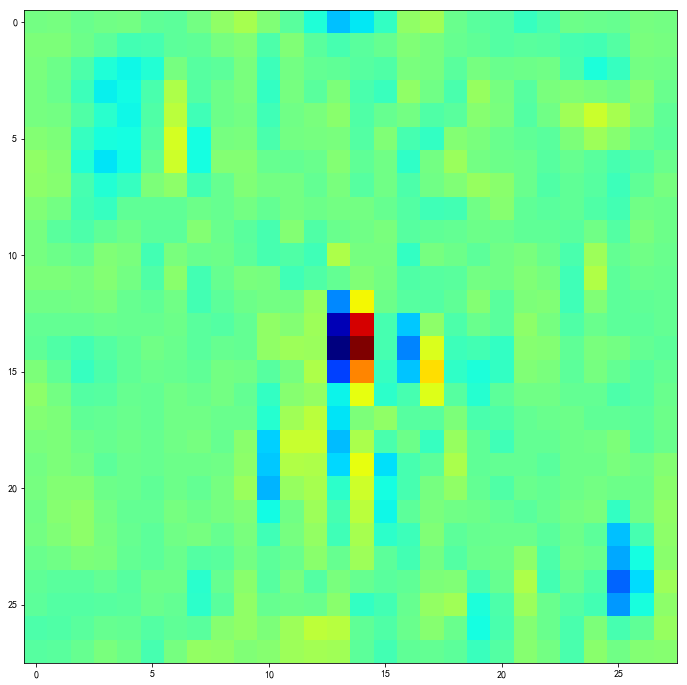

In [30]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

#找到最后一层
layer_idx = utils.find_layer_idx(model2, 'preds')

# 把最后一层的softmax激活函数替换为线性
model2.layers[layer_idx].activation = keras.activations.linear
model2 = utils.apply_modifications(model2)

grads = visualize_saliency(model2, layer_idx, filter_indices=class_idx, seed_input=X_test[idx], 
                           backprop_modifier=None, 
                           grad_modifier=None)
# 使用热图
plt.imshow(grads, cmap='jet')